# Variational Quantum Algorithms

Variational quantum algorithms is clearly explained in [this short course of IBM](https://learning.quantum.ibm.com/course/variational-algorithm-design), I will quote some main idea here, and write some comment coming to me when reading about VQA. I will also implement a toy model in the end.

# VQA main idea

I am from a physics background, so I feel VQA bears much similarity to the variational quamtum Monte Carlo algorithms (VMC) in physics / chemistry. In VMC, one introduce a trial wave function $\Psi(\theta)$ with parameters, and vary the parameters $\theta$ to minimize the energy $\langle H \rangle$, while the energy (an integral) is calculated using Monte Carlo algorithms.
The outline of VMC is:
1. Start from some antisymmetric wave function (e.g., slater determinant from Hartree-Fock);
2. Add a JS factor with some variational parameters, composing the variational ansatz;
3. In an inner loop, Monte Carlo is used to calculate the energy $E(\theta)=\langle H \rangle$;
4. In an outer loop, $E(\theta)$ is minimized to get the optimal $\theta$.

Variational Quantum Algorithms have almost the same logic: minimizing the expectaion of some operator $\langle H \rangle$ by varing the parameters in the states $|\psi(\theta)\rangle$. However, in VQA's, the ansatz $|\psi(\theta)\rangle$ and the "energy" $\langle H \rangle$ is calculated through a quantum circuit. Its outline is:
1. Get a reference state from the default input: $|0\rangle \xrightarrow{U_R} |\rho\rangle$;
2. Using a parametrized circuit to get the parametrized ansatz: $|\rho\rangle \xrightarrow{U_T(\theta)} |\psi(\theta)\rangle$;
3. The quantum circuit is sampled to get the expected energy $E(\theta)=\langle \psi(\theta)|H|\psi(\theta)\rangle$;
4. An outer loop is used to minimize $E(\theta)$.

Roughly speaking, I found VMC and VQA has many features in common:
- They directly utilize the Quantum mechanics variational theorem;
- They are composed of two procedures (optimization and evaluation of energy);
- They need an ansatz (probably carefully designed) to get a result;
- The evaluation of energy is prone to noise / error.

However, there are also features setting them apart:
- VQA runs the ansatz on an quantum computer, which possibly support ansatz hard to simulate on classical computers, and is hopefully (I guess) more suited for quantum systems. 
- Once the ansatz is fixed, VMC is only prone to statistical error, but VQA is possibly also prone to noise and failure in the quantum circuits. Thus, (at least at the current stage) VQA requires some error suppresion / mitigation techniques, and is more sensitive to the hardware.

# Key words
Key words quoted from the course VQA on ibm learning (I add some details):
1. Initialize the problem:
    1. Default State.
    2. Classical References State.
    3. Quantum Reference State.
    4. Aplication-Specific Reference States.
2. prepare ansatz:
    1. parametrized quantum circuits.
    2. Variational form, and ansatz.
    3. Heuristic ansatz: N-local circuits (*somewhat reminiscent of a neural network*), EfficientSU2.
    4. Problem-Specific ansatz: QAOAAnsatz.
3. Evaluate cost function:
    1. Cost functions.
    2. Primitives: Sampler and Estimator.
    3. Measurement stategy: Speed vs accuracy.
    4. Error mitgation and suppresion using qiskit runtime: mitigation methods (twirled readout error extinction, zero noise extrapolation, probabilistic error cancellation).
4. Optimize parameters to get results:
    1. Bootstrapping optimization.
    2. Local and Global Optimizations
    3. Barren Plateaus.
    4. Gradient-Based and Gradient-Free Optimizers.

# Implementation
I will try to calculate the ground state energy of an open 1d Ising chain of length $L$ here. An 1d Ising chain is a 1d lattice, with a spin (a qubit) fixed at each lattice site. The Hamiltonian is defined as
$$H = -J\sum_{i=0}^{L-2}Z_iZ_{i+1}.$$
I will set $J=1$. The ground state is actually pretty tivial, i.e., all spins pointing at the same direction, with $E_{gs}=-L+1$, but I will try to reproduce it through VQA.

## Classical diagonalizaion
I will first explicitly construct and diagnlize the matrix, and the result should be exact (up to machine precision).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%config InlineBackend.figure_format = "svg"

In [9]:
Z = np.array([[1, 0], [0, -1]])
ZZ = np.kron(Z, Z)
I = np.eye(2)

In [32]:
def H_Ising(L: int):
    '''Return the full Hamiltonian matrix of an open Ising chain of length L'''
    H = np.zeros([2, 2])
    for i in range(L-1):
        H = np.kron(H, I)
        H += np.kron(np.eye(2**i), ZZ)
    assert np.allclose(H, H.T)
    return H
        

In [33]:
H_list = [H_Ising(i) for i in range(2, 11)]
E_list = []
for H in H_list:
    eigE, eigv = np.linalg.eigh(H)
    E_list.append(eigE[0])

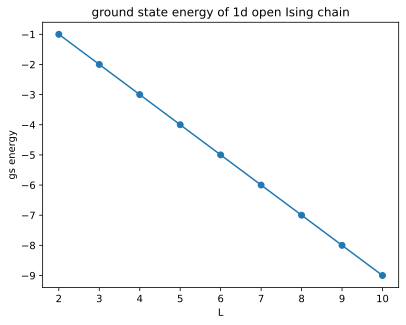

In [34]:
plt.plot(np.arange(2, 11), E_list, marker="o")
plt.ylabel("gs energy")
plt.xlabel("L")
plt.title("ground state energy of 1d open Ising chain")
plt.show()

## VQA: Variational Quantum Eigen Solver (VQE)

In [57]:
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from scipy.optimize import minimize

In [58]:
def cost(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [59]:
def build_H(L):
    H_list = []
    for i in range(L - 1):
        neighbor = "I" * i + "ZZ" + "I" * (L - i - 2)
        H_list.append((neighbor, -1))
    return SparsePauliOp.from_list(H_list)

Number of parameters: 20


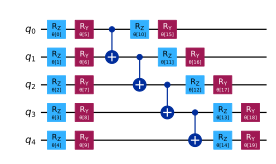

In [63]:
# Test the ansatz
H_5 = build_H(5)
# ansatz_5 = QAOAAnsatz(H_5, reps=1)
ansatz_5 = TwoLocal(
    5,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
print("Number of parameters:", len(ansatz_5.parameters))
ansatz_5.decompose().draw("mpl", scale=0.6)

In [64]:
# Try calculating the result
estimator = Estimator()
result = minimize(cost, np.ones(len(ansatz_5.parameters)),
                  args=(ansatz_5, H_5, estimator), method="COBYLA")
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.999999985114687
       x: [ 1.487e+00  3.389e-01 ...  1.571e+00  1.571e+00]
    nfev: 600
   maxcv: 0.0

In [78]:
# Try calculating the result on different size
H_list_q = [build_H(i) for i in range(2, 11)]
E_list_q = []
for i, H in zip(range(2,11), H_list_q):
    ansatz = TwoLocal(
        i,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
        )
    result = minimize(cost, np.ones(len(ansatz.parameters)),
                      args=(ansatz, H, estimator), method="COBYLA")
    E_list_q.append(result.fun)

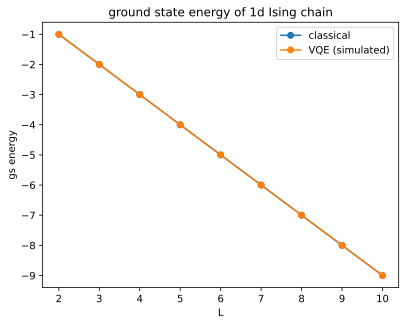

In [82]:
plt.plot(range(2, 11), E_list, marker="o", label="classical")
plt.plot(range(2, 11), E_list_q, marker="o", label="VQE (simulated)")
plt.legend()
plt.xlabel("L")
plt.ylabel("gs energy")
plt.title("ground state energy of 1d Ising chain")
plt.show()

The result of classical diagnolization and variational quantum eigen solver (exactly simulated) concide, reproducing the ground state energy of an open Ising chain.

# Reference
[1] The course on IBM learning: https://learning.quantum.ibm.com/course/variational-algorithm-design.